# Raw Depth Projection Tutorial

### This tutorial shows how to do a cylindrical depth projection of the 3D LiDAR point clouds

#### 1. Download the raw point cloud data
You can find the link to download the raw data for the LiDAR point clouds [here](https://github.com/scaleapi/pandaset-devkit/issues/67#issuecomment-674403708).
In the following we define `/data/pandaset` as the location of the data.

#### 2. Import required python modules

In [1]:
import csv
import gzip
import pickle
import numpy as np
import matplotlib.pyplot as plt

#### 3. Load the raw sensor data
The description of the raw sensor data is provided in [Data.Instructions.pdf](https://github.com/scaleapi/pandaset-devkit/files/5078794/PandaSet.Raw.Data.Instructions.pdf).
The data directly provides the laser and column id for each measured point.

In [2]:
file = "/data/pandaset/001/lidar/00.pkl.gz"
with gzip.open(file, "rb") as fin:
    data = pickle.load(fin)

num_rows = 64  # the number of lasers
num_columns = int(360 / 0.2)  # horizontal field of view / horizontal angular resolution

        laser_id  column_id  elevation  azimuth_col  azimuth_col_corrected  \
0              8      37793      1.510   354.850006             360.058014   
1             14      37793      0.496   354.850006             360.058014   
2             20      37793     -0.520   354.850006             360.058014   
3             26      37793     -1.534   354.850006             360.058014   
4             32      37793     -2.548   354.850006             360.058014   
...          ...        ...        ...          ...                    ...   
106881        13      39644      0.663     5.050000               8.175000   
106882        18      39644     -0.181     5.050000               6.092000   
106883        39      39644     -3.724     5.050000              -0.158000   
106884        45      39644     -4.732     5.050000              -0.158000   
106885        51      39644     -5.738     5.050000              -0.158000   

          distance  intensity  
0        84.695999         39  

#### 3. Load the horizontal angle offets
The column ids of the raw data are those collected at the same motor rotation angle. This is not the same horizontal angle, due to horizontal angle offsets in the mounting position of the lasers.
With the data provided in the `csv` file, taken from the Pandar64 User Manual, we can correct the column ids to sort the points accordingly.

In [3]:
with open("pandar64_channel_distribution.csv", "r") as fin:
    reader = csv.DictReader(fin)
    horizontal_angle_offset = np.array([float(r["horizontal_angle_offset"]) for r in reader])

column_shift = (num_columns / 360 * horizontal_angle_offset).astype(np.int64)

#### 4. Retrieve the laser and column ids
The column ids are given in absolute values, therefore we have to substract the smallest value to obtain the indices relative to the current frame. Due to the angle offets, the span from minimum to maximum value is exactly 1852 per frame instead of 1800. This is since the maximum offset in both positive and negative is 26 `>> 2 * 26 = 52`. With the offsets we can compute the correct column ids.

In [4]:
rows_list = data["laser_id"].values

cols_list = data["column_id"].values
cols_list -= np.min(cols_list)
cols_list = np.mod(cols_list + column_shift[rows_list] + num_columns, num_columns)

#### 5. Create the depth projection
First, we initialize an empty image. All locations without measurements will have the value `-1`. Then we scatter the point cloud into the image.

In [5]:
depth_img = np.full((num_rows, num_columns), fill_value=-1, dtype=np.float32)
depth_img[rows_list, cols_list] = data["distance"].values

(64, 1800)
[[ -1.     -1.     -1.    ...  -1.     16.24   16.304]
 [ -1.     -1.     -1.    ...  42.98   43.068  43.112]
 [101.408 101.288 101.24  ... 101.504 101.456 101.4  ]
 ...
 [  8.08    8.076   8.064 ...   8.096   8.084   8.072]
 [ -1.     -1.     -1.    ...  -1.     -1.     -1.   ]
 [  1.008   0.964   0.956 ...  -1.      1.032   0.908]]


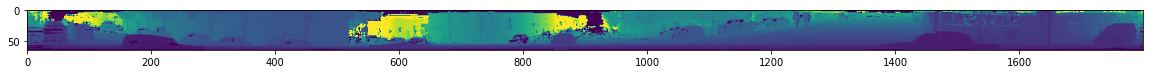

In [6]:
plt.figure(figsize=(20, 4))
plt.imshow(depth_img, vmin=0.5, vmax=80)
plt.show()